Source: https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt

c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

In [3]:
data = pd.read_excel(r'C:\Users\aliki\Desktop\NLP\vol_3\labeled_data_v3.xlsx')

## An Overlook to Our Data

We are adding a column that displays how many word the corresponding comment has.

In [4]:
df = data
df['count'] = df['comment'].apply(lambda x : len(x.split()))
print(df.head())

                                             comment  source  label  count
0  As a woman you shouldn't complain about cleani...  kaggle      0     21
1  boy dats cold...tyga dwn bad for cuffin dat ho...  kaggle      1     13
2  Dawg!!!! You ever fuck a bitch and she start t...  kaggle      1     16
3  The shit you hear about me might be true or it...  kaggle      1     22
4  The shit just blows me..claim you so faithful ...  kaggle      1     17


We are checking if all the comments have labels.

In [5]:
df.count()

comment    3835
source     3835
label      3835
count      3835
dtype: int64

We are checking if we have a comment that has more than 512 words. Because BERT tokenizer has a limit of 512.

In [6]:
df[df['count']>512]

,comment,source,label,count


c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Number of Words Distribution')

<Figure size 800x800 with 0 Axes>

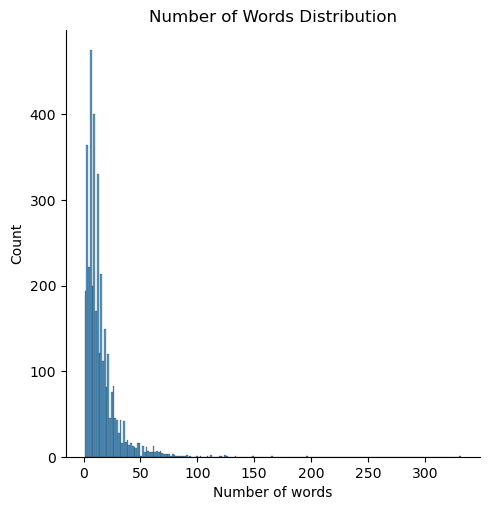

In [7]:
plt.figure(figsize=(8,8))
sns.displot(df['count'])
plt.xlabel('Number of words')   
plt.title('Number of Words Distribution')

We are checking how many comments are labeled as 0 and 1 to get a better understanding of our data.

In [8]:
df[df['label']==1].shape

(907, 4)

In [9]:
df[df['label']==0].shape

(2928, 4)

c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


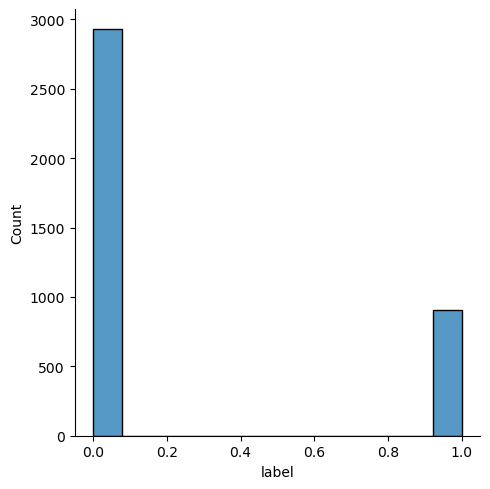

In [10]:
sns.displot(df['label'])

## An Overlook to Our Data Sources

c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x300 with 0 Axes>

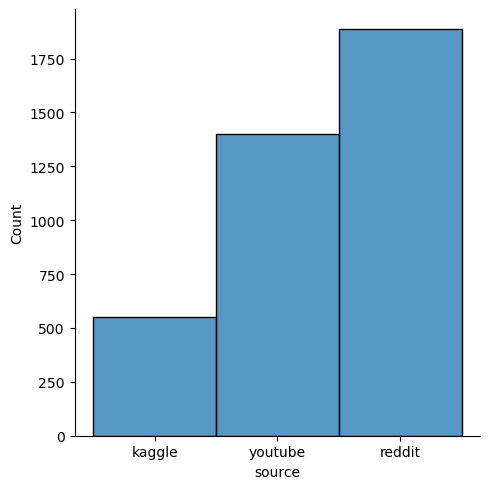

In [11]:
plt.figure(figsize=(12,3))
sns.displot(df['source'])

# Now We Can Start!!!

## Initializing Pretrained Model and Tokenizer

In [12]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Preprocessing Text with Pretrained Tokenizer

We are using validation data ( X_val, y_val) as test data

In [13]:
X = list(data["comment"])
y = list(data["label"])

In [14]:

X_train_temp, X_1, y_train_temp, y_1 = train_test_split(X, y, test_size=0.333)


In [15]:
len(y_train_temp)

2557

In [16]:
len(X_1)

1278

In [17]:
X_2, X_3, y_2, y_3 = train_test_split(X_train_temp, y_train_temp, test_size=0.5)

In [18]:
len(X_2)

1278

In [19]:
len(X_3)

1279

In [20]:
X_train_1 = X_1 + X_2
y_train_1 = y_1 + y_2
X_test_1 = X_3
y_test_1 = y_3

In [21]:
X_train_2 = X_1 + X_3
y_train_2 = y_1 + y_3
X_test_2 = X_2
y_test_2 = y_2

In [22]:
X_train_3 = X_3 + X_2
y_train_3 = y_3 + y_2
X_test_3 = X_1
y_test_3 = y_1

## First Training

In [23]:
X_train_tokenized_1 = tokenizer(X_train_1, padding=True, truncation=True, max_length=512)
X_test_tokenized_1 = tokenizer(X_test_1, padding=True, truncation=True, max_length=512)

Checking the train and validation values

## Creating a Torch Dataset

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized_1, y_train_1)
test_dataset = Dataset(X_test_tokenized_1, y_test_1)

## Defining TrainingArguments and Trainer

In [25]:
def compute_metrics(p, l):
    pred = p
    labels = l
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [26]:
args = TrainingArguments(
    output_dir="output_1",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer_1 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    #compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

## Training the Model

In [27]:
trainer_1.train()

c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2556
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 960
  Number of trainable parameters = 109483778
 52%|█████▏    | 500/960 [1:31:18<1:24:30, 11.02s/it]***** Running Evaluation *****
  Num examples = 1279
  Batch size = 8


{'loss': 0.3305, 'learning_rate': 2.3958333333333334e-05, 'epoch': 1.56}


                                                     
 52%|█████▏    | 500/960 [1:54:46<1:24:30, 11.02s/it]Saving model checkpoint to output_1\checkpoint-500
Configuration saved in output_1\checkpoint-500\config.json


{'eval_loss': 0.40629133582115173, 'eval_runtime': 1408.3981, 'eval_samples_per_second': 0.908, 'eval_steps_per_second': 0.114, 'epoch': 1.56}


Model weights saved in output_1\checkpoint-500\pytorch_model.bin
100%|██████████| 960/960 [3:13:50<00:00,  8.67s/it]    

Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output_1\checkpoint-500 (score: 0.40629133582115173).
100%|██████████| 960/960 [3:13:51<00:00, 12.12s/it]

{'train_runtime': 11631.327, 'train_samples_per_second': 0.659, 'train_steps_per_second': 0.083, 'train_loss': 0.24045471350351968, 'epoch': 3.0}


TrainOutput(global_step=960, training_loss=0.24045471350351968, metrics={'train_runtime': 11631.327, 'train_samples_per_second': 0.659, 'train_steps_per_second': 0.083, 'train_loss': 0.24045471350351968, 'epoch': 3.0})

## Making Prediction

In [28]:
model_path = "output_1/checkpoint-500"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

loading configuration file output_1/checkpoint-500\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file output_1/checkpoint-500\pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenc

In [29]:
test_trainer = Trainer(model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [30]:
raw_pred_1, _, _ = test_trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1279
  Batch size = 8
100%|██████████| 160/160 [22:59<00:00,  8.62s/it]


# 1st Training Results

In [31]:
compute_metrics(raw_pred_1, y_test_1)

{'accuracy': 0.8983580922595777,
 'precision': 0.8765957446808511,
 'recall': 0.6710097719869706,
 'f1': 0.7601476014760148}

In [32]:
y_pred_1 = np.argmax(raw_pred_1, axis=1)

In [33]:
type(y_test_1)

list

In [34]:
type(y_pred_1)

numpy.ndarray

In [35]:
y_pred_1 = list(y_pred_1)

In [36]:
confusion_matrix(y_test_1, y_pred_1)

array([[943,  29],
       [101, 206]], dtype=int64)

## 2nd Training

In [37]:
X_train_tokenized_2 = tokenizer(X_train_2, padding=True, truncation=True, max_length=512)
X_test_tokenized_2 = tokenizer(X_test_2, padding=True, truncation=True, max_length=512)

In [38]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset_2 = Dataset(X_train_tokenized_2, y_train_2)
test_dataset_2 = Dataset(X_test_tokenized_2, y_test_2)

In [39]:
args = TrainingArguments(
    output_dir="output_2",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer_2 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_2,
    eval_dataset=test_dataset_2,
    #compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [40]:
trainer_2.train()

c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2557
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 960
  Number of trainable parameters = 109483778


 52%|█████▏    | 500/960 [2:37:33<2:17:59, 18.00s/it]***** Running Evaluation *****
  Num examples = 1278
  Batch size = 8


{'loss': 0.2374, 'learning_rate': 2.3958333333333334e-05, 'epoch': 1.56}


                                                     
 52%|█████▏    | 500/960 [2:49:14<2:17:59, 18.00s/it]Saving model checkpoint to output_2\checkpoint-500
Configuration saved in output_2\checkpoint-500\config.json


{'eval_loss': 0.27261877059936523, 'eval_runtime': 701.1361, 'eval_samples_per_second': 1.823, 'eval_steps_per_second': 0.228, 'epoch': 1.56}


Model weights saved in output_2\checkpoint-500\pytorch_model.bin
100%|██████████| 960/960 [5:19:14<00:00, 17.38s/it]    

Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output_2\checkpoint-500 (score: 0.27261877059936523).
100%|██████████| 960/960 [5:19:15<00:00, 19.95s/it]

{'train_runtime': 19155.196, 'train_samples_per_second': 0.4, 'train_steps_per_second': 0.05, 'train_loss': 0.16130742232004802, 'epoch': 3.0}


TrainOutput(global_step=960, training_loss=0.16130742232004802, metrics={'train_runtime': 19155.196, 'train_samples_per_second': 0.4, 'train_steps_per_second': 0.05, 'train_loss': 0.16130742232004802, 'epoch': 3.0})

In [42]:
model_path = "output_2/checkpoint-500"
model_2 = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

loading configuration file output_2/checkpoint-500\config.json
Model config BertConfig {
  "_name_or_path": "output_1/checkpoint-500",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file output_2/checkpoint-500\pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForS

In [45]:
test_trainer_2 = Trainer(model_2)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [46]:
raw_pred_2, _, _ = test_trainer_2.predict(test_dataset_2)

***** Running Prediction *****
  Num examples = 1278
  Batch size = 8
100%|██████████| 160/160 [12:47<00:00,  4.79s/it]


In [47]:
compute_metrics(raw_pred_2, y_test_2)

{'accuracy': 0.9287949921752738,
 'precision': 0.8134110787172012,
 'recall': 0.9117647058823529,
 'f1': 0.859784283513097}

In [49]:
y_pred_2 = np.argmax(raw_pred_2, axis=1)
y_pred_2 = list(y_pred_2)
confusion_matrix(y_test_2, y_pred_2)

array([[908,  64],
       [ 27, 279]], dtype=int64)

## 3rd Training

In [50]:
X_train_tokenized_3 = tokenizer(X_train_3, padding=True, truncation=True, max_length=512)
X_test_tokenized_3 = tokenizer(X_test_3, padding=True, truncation=True, max_length=512)

In [51]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset_3 = Dataset(X_train_tokenized_3, y_train_3)
test_dataset_3 = Dataset(X_test_tokenized_3, y_test_3)

In [54]:
args = TrainingArguments(
    output_dir="output_3",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer_3 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_3,
    eval_dataset=test_dataset_3,
    #compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [55]:
trainer_3.train()

c:\Users\aliki\anaconda3\envs\NLPProject\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2557
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 960
  Number of trainable parameters = 109483778


 52%|█████▏    | 500/960 [3:00:19<2:12:27, 17.28s/it]***** Running Evaluation *****
  Num examples = 1278
  Batch size = 8


{'loss': 0.1793, 'learning_rate': 2.3958333333333334e-05, 'epoch': 1.56}


                                                     
 52%|█████▏    | 500/960 [3:05:55<2:12:27, 17.28s/it]Saving model checkpoint to output_3\checkpoint-500
Configuration saved in output_3\checkpoint-500\config.json


{'eval_loss': 0.06027203053236008, 'eval_runtime': 336.036, 'eval_samples_per_second': 3.803, 'eval_steps_per_second': 0.476, 'epoch': 1.56}


Model weights saved in output_3\checkpoint-500\pytorch_model.bin
100%|██████████| 960/960 [5:17:48<00:00, 15.22s/it]    

Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output_3\checkpoint-500 (score: 0.06027203053236008).
100%|██████████| 960/960 [5:17:48<00:00, 19.86s/it]

{'train_runtime': 19068.518, 'train_samples_per_second': 0.402, 'train_steps_per_second': 0.05, 'train_loss': 0.11873215039571126, 'epoch': 3.0}


TrainOutput(global_step=960, training_loss=0.11873215039571126, metrics={'train_runtime': 19068.518, 'train_samples_per_second': 0.402, 'train_steps_per_second': 0.05, 'train_loss': 0.11873215039571126, 'epoch': 3.0})

In [56]:
model_path = "output_3/checkpoint-500"
model_3 = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

loading configuration file output_3/checkpoint-500\config.json
Model config BertConfig {
  "_name_or_path": "output_2/checkpoint-500",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file output_3/checkpoint-500\pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForS

In [57]:
test_trainer_3 = Trainer(model_2)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [58]:
raw_pred_3, _, _ = test_trainer_3.predict(test_dataset_3)

***** Running Prediction *****
  Num examples = 1278
  Batch size = 8
100%|██████████| 160/160 [06:15<00:00,  2.35s/it]


In [59]:
compute_metrics(raw_pred_3, y_test_3)

{'accuracy': 0.9874804381846636,
 'precision': 0.9664429530201343,
 'recall': 0.9795918367346939,
 'f1': 0.9729729729729729}

In [60]:
y_pred_3 = np.argmax(raw_pred_3, axis=1)
y_pred_3 = list(y_pred_3)
confusion_matrix(y_test_3, y_pred_3)

array([[974,  10],
       [  6, 288]], dtype=int64)